In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
import os
import subprocess
import pareto
import matplotlib

# Step 2: Analyzing MORO Optimization Results

After running the Multi-Objective Robust Optimization (MORO) using two different approaches and 5 different seeds in the `Step2_Simulate_MORO_Optimisation.py` file in this directory, we have obtained a wide range of potential Pareto optimal solutions. 

In the first approach, we used MORO to minimize the 90th percentile of costs, damages and deaths under 100 different scenarios per policy. This approach was chosen to identify policies that perform well even under adverse conditions (e.g., worst-case scenarios). 

In the second approach, we applied MORO to minimize the means of costs, damages and deaths over 100 scenarios per policy. This approach aimed to provide policies that did not just do good in the 90th percentile, but that have the best performance across scenarios.

In this notebook, we will go into the following topics:

1. **Convergence Metrics**: Evaluating metrics such as Epsilon Progress and HyperVolume to assess how effectively MORO converged towards Pareto optimal solutions.
2. **Pareto Sorting to Merge Outcomes**: Merging outcomes from different seeds and measurement types, to remove double outcomes and outcomes that in the same epsilon values square.


# 1. Convergence Metrics
In Multi-Objective Robust Optimization (MORO), convergence metrics are crucial for assessing the algorithm's effectiveness in identifying Pareto optimal solutions. These metrics provide quantitative measures of the optimization process, tracking how close the algorithm comes to achieving optimal trade-offs between conflicting objectives.

Our analysis will focus on two key convergence metrics: Epsilon Progress and HyperVolume. Epsilon Progress tracks the algorithm's progress towards satisfying predefined trade-off levels (epsilons), indicating its ability to balance conflicting objectives. HyperVolume measures the volume of the objective space dominated by non-dominated solutions found by the algorithm, offering insights into the diversity and quality of Pareto optimal solutions discovered.

Understanding these convergence metrics is essential for evaluating the robustness and quality of policy solutions derived from MORO. This section will therefore examine these metrics to gain a deeper understanding of how well the optimization process performs across different robustness functions and seeds.

## Loading CSVs (MORO Convergence Outputs)
We set the directory paths and load the convergence metrics files for each seed and for the different metrics. This data will be used to visualize the optimization process.

In [2]:
# Get the current working directory and navigate to the data/output_data directory
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data', 'output_data', 'Step2')

# Load the convergence metrics files for the 90th percentile
metrics_90_seed_1362 = pd.read_csv(os.path.join(data_dir, '90', 'convergence_metrics_90_seed_1362.csv'))
metrics_90_seed_1363 = pd.read_csv(os.path.join(data_dir, '90', 'convergence_metrics_90_seed_1363.csv'))
metrics_90_seed_1364 = pd.read_csv(os.path.join(data_dir, '90', 'convergence_metrics_90_seed_1364.csv'))
metrics_90_seed_1365 = pd.read_csv(os.path.join(data_dir, '90', 'convergence_metrics_90_seed_1365.csv'))

# Load the convergence metrics files for the mean
metrics_mean_seed_1362 = pd.read_csv(os.path.join(data_dir, 'mean', 'convergence_metrics_mean_seed_1362.csv'))
metrics_mean_seed_1363 = pd.read_csv(os.path.join(data_dir, 'mean', 'convergence_metrics_mean_seed_1363.csv'))
metrics_mean_seed_1364 = pd.read_csv(os.path.join(data_dir, 'mean', 'convergence_metrics_mean_seed_1364.csv'))
metrics_mean_seed_1365 = pd.read_csv(os.path.join(data_dir, 'mean', 'convergence_metrics_mean_seed_1365.csv'))

The `plot_convergence_metrics` function shown below is crafted to visualize the Epsilon Convergence and HyperVolume metrics derived from DataFrames previously created. It constructs two subplots: one dedicated to Epsilon Progress and the other to Hypervolume. Each seed is represented with a distinct color in the plots. These visualizations aid in comprehending the convergence of optimization across the number of function evaluations (NFE).

In [3]:
def plot_convergence_metrics(metrics_list, seeds, type):
    current_dir = os.getcwd()
    dir = os.path.join(current_dir, 'data', 'plots', 'Step2')
    os.makedirs(dir, exist_ok=True)    
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(14, 6))

    # Define colors using the Set3 colormap
    cmap = matplotlib.colormaps['tab10']
    colors = [cmap(i) for i in range(len(seeds))]
    
    # Plot for each seed
    for metrics, seed, color in zip(metrics_list, seeds, colors):
        ax1.plot(metrics['nfe'], metrics['epsilon_progress'], label=f'Seed {seed}', color=color)
        ax2.plot(metrics['nfe'], metrics['hypervolume'], label=f'Seed {seed}', color=color)

    # First plot settings
    ax1.set_xlabel('Number of Function Evaluations (NFE)')
    ax1.set_ylabel('Epsilon Progress')
    ax1.set_title('Convergence of Epsilon Progress')
    ax1.legend()

    # Second plot settings
    ax2.set_xlabel('Number of Function Evaluations (NFE)')
    ax2.set_ylabel('Hypervolume')
    ax2.set_title('Convergence of Hypervolume')
    ax2.legend()

    # Apply grid and customize layout for both plots
    for ax in [ax1, ax2]:
        ax.grid(True, which='both', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('gray')
        ax.spines['bottom'].set_color('gray')
        ax.tick_params(colors='gray', labelsize=16)
        ax.yaxis.get_label().set_fontsize(18)
        ax.xaxis.get_label().set_fontsize(18)
        ax.title.set_fontsize(20)

    plt.tight_layout()
    plt.savefig(os.path.join(dir, f'convergence_metrics_{type}.png'))
    plt.show()

Now that the function is set up, we can run it. We will apply it twice: once for the convergence metrics of the 90th percentile-based MORO, and once for the convergence metrics of the mean-based MORO. We will run the function using all four runs/seeds for both cases, and the outcomes are shown below. After each plot, we will discuss the results.

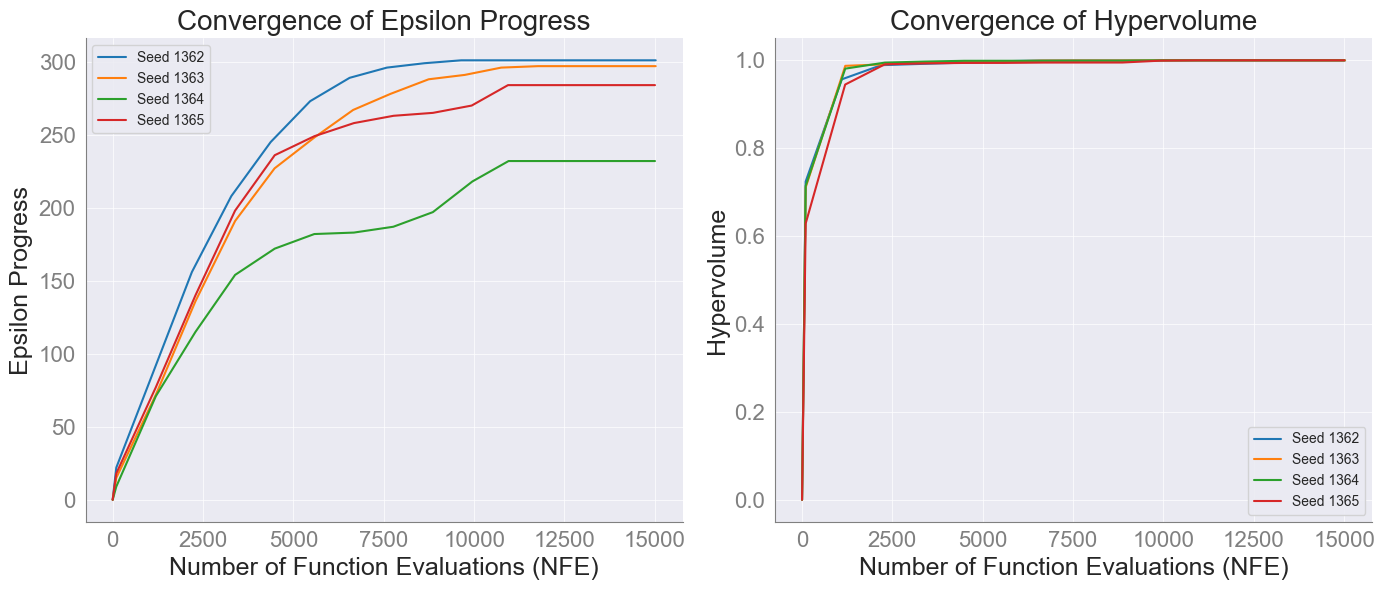

In [4]:
# List of metrics and seeds
metrics_list = [metrics_90_seed_1362, metrics_90_seed_1363, metrics_90_seed_1364, metrics_90_seed_1365]
seeds = [1362, 1363, 1364, 1365]

# Plot convergence metrics for all seeds in a single plot
plot_convergence_metrics(metrics_list, seeds, '90')

### Discussion of Results for 90th Percentile-Based Optimization

The first plot shows the convergence of Epsilon Progress over the number of function evaluations (NFE). Epsilon Progress tracks the algorithm's ability to balance conflicting objectives by satisfying predefined trade-off levels (epsilons). In our analysis, we observe that the Epsilon Progress stabilizes around 11,000 NFE. This stabilization indicates that the algorithm has effectively balanced the trade-offs between objectives (costs, damages, deaths) and is no longer making significant improvements. Reaching a stable point suggests that the MORO process has identified a set of robust policies that perform well even under adverse conditions, reflecting the resilience of these policies against the worst-case scenarios considered.

The second plot illustrates the convergence of HyperVolume over NFE. HyperVolume measures the volume of the objective space dominated by the non-dominated solutions found by the algorithm. We note that the HyperVolume converges around 2,500 NFE. This early convergence of HyperVolume indicates that the algorithm quickly identifies a diverse set of high-quality Pareto optimal solutions. This rapid stabilization suggests that the algorithm is efficient in exploring the objective space and finding optimal trade-offs between conflicting objectives. A stable HyperVolume signifies that the identified solutions maintain a good balance between objectives and have a wide range of optimal trade-offs, providing a comprehensive set of policy options for decision-makers.

These results demonstrate that the MORO approach is effective in producing a diverse and high-quality set of Pareto optimal solutions, providing valuable policy options that balance costs, damages, and deaths under adverse conditions.


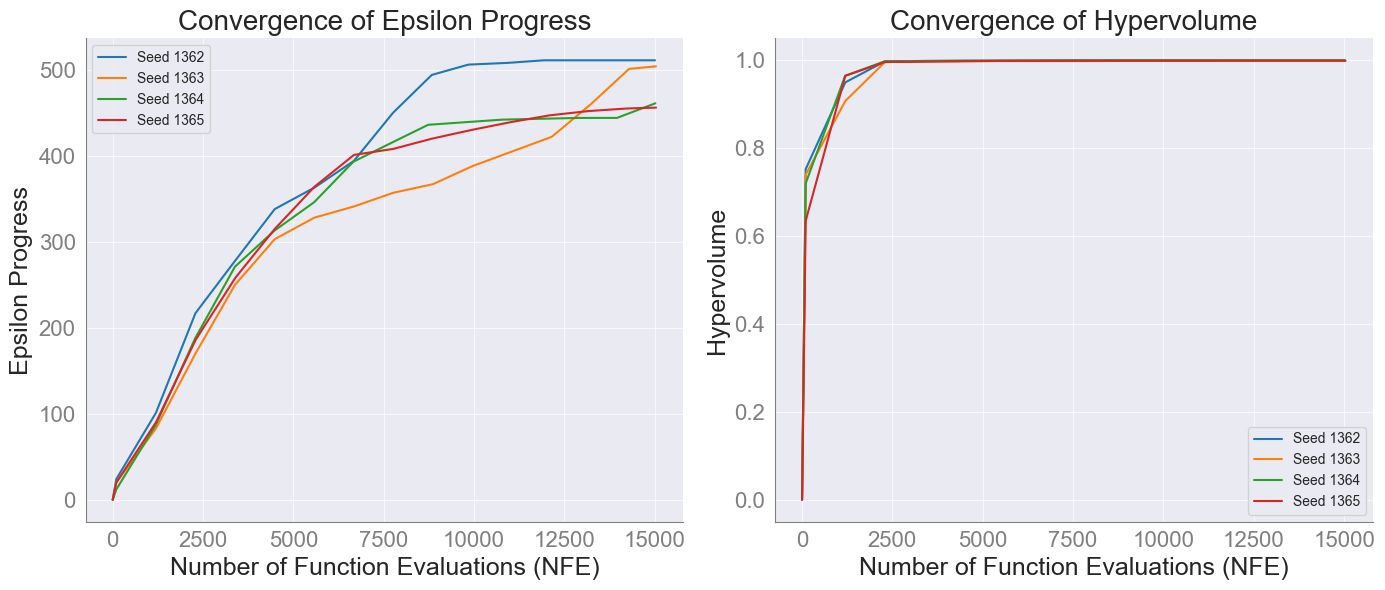

In [5]:
# List of metrics and seeds
metrics_list = [metrics_mean_seed_1362, metrics_mean_seed_1363, metrics_mean_seed_1364, metrics_mean_seed_1365]
seeds = [1362, 1363, 1364, 1365]

# Plot convergence metrics for all seeds in a single plot
plot_convergence_metrics(metrics_list, seeds, 'mean')

### Discussion of Results for Mean-Based Optimization

The first plot again shows the convergence of Epsilon Progress over the number of function evaluations (NFE). In the plot above analysis, we observe that the Epsilon Progress stabilizes around 15,000 NFE (but is not completely stabilized). This again means the algorithm is no longer making significant improvements. Reaching a stable point suggests that the MORO process has identified a set of robust policies whose mean deaths, damages, and investment are pareto optimal.

The second plot again illustrates the convergence of HyperVolume over NFE. As visible the HyperVolume converges around 2,500 NFE. This early convergence of HyperVolume indicates that the algorithm quickly identifies a diverse set of high-quality Pareto optimal solutions.

These results demonstrate that the MORO approach is effective in producing a diverse and high-quality set of Pareto optimal solutions, providing valuable policy options that balance the mean costs, damages, and deaths under different scenarios.


# 2. Pareto Sorting to Merge Outcomes
In this section the outcomes from the five different seeds will be merged. Using the epsilon value, we will only keep pareto optimal solutions, from the entire set of policies. 

First we load the optimization archives for both the mean and 90th percentile optimization outcomes for all five seeds. We do this below and create two merged dataframes, one for 90th percentile outcomes, and one for mean outcomes.

In [6]:
# Define the base directory
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data', 'output_data', 'Step2')

# Categories and seeds
categories = ['90', 'mean']
seeds = [1362, 1363, 1364, 1365]

# Dictionary to map categories to their respective DataFrame lists
archives = {
    '90': [],
    'mean': []
}

# Load files from each category
for category in categories:
    for seed in seeds:
        file_name = f'optimization_archive_{category}_seed_{seed}.csv'
        file_path = os.path.join(data_dir, category, file_name)
        # Check if the file exists before loading
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            if 'Unnamed: 0' in df.columns:
                df = df.drop(columns='Unnamed: 0')
            archives[category].append(df)
        else:
            print(f"File not found: {file_path}")

# Concatenate the DataFrame lists into three separate DataFrames
merged_df_90 = pd.concat(archives['90'], ignore_index=True) if archives['90'] else pd.DataFrame()
merged_df_mean = pd.concat(archives['mean'], ignore_index=True) if archives['mean'] else pd.DataFrame()

# Example output to verify the data
print("Merged Archives 90:")
print(merged_df_90.head())
print("\nMerged Archives Mean:")
print(merged_df_mean.head())

Merged Archives 90:
   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2_RfR 2  3_RfR 0  ...  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0        0        1  ...                   0                   0   
1        0        1  ...                   0                   2   
2        0        1  ...                   0                   3   
3        0        1  ...                   0                   4   
4        0        1  ...                   0                   1   

   A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                   0                   0  

Now that we have established the two different merged dataframes, we can compare the outcomes of interest across the different seeds. Our goal is to determine whether some outcomes can be considered equivalent within the specified epsilon values.

The cell below sets up a function to check if multiple outcomes fall within the same epsilon range. If they do, only the one closest to the origin (determined using the Pythagorean theorem) will be retained. After applying this function, we create two new files named `merged_archives_mean_nondominated.csv` and `merged_archives_90_nondominated.csv`.

In [7]:
def apply_general_nondominated_sorting(df, data_dir, file_suffix):
    # Convert DataFrame to a list of lists
    data_as_list = df.values.tolist()

    # Automatically pick the last three columns as the objective columns
    objective_indices = [-3, -2, -1]  # Indices for the last three columns

    # Define epsilon values for each objective
    epsilon_values = [0.05, 0.05, 0.05]

    # Run epsilon-nondominated sorting
    nondominated = pareto.eps_sort([data_as_list], objective_indices, epsilon_values)

    # Extract the relevant rows from the nondominated solutions
    nondominated_solutions = [solution for solution in nondominated]

    # Convert back to DataFrame using the original column names
    nondominated_df = pd.DataFrame(nondominated_solutions, columns=df.columns)
    
    # Saving results to a file
    output_file = os.path.join(data_dir, f'merged_archives_{file_suffix}_nondominated.csv')
    nondominated_df.to_csv(output_file, index=False)

    return nondominated_df

We now apply the function to both the 90th percentile and mean dataframe.

In [8]:
# Example usage (assuming 'data_dir' and the merged DataFrames are already defined)
nondominated_90 = apply_general_nondominated_sorting(merged_df_90, data_dir, '90')
nondominated_mean = apply_general_nondominated_sorting(merged_df_mean, data_dir, 'mean')

# Output verification
print("Nondominated solutions for 90:")
print(nondominated_90.head())
print("\nNondominated solutions for Mean:")
print(nondominated_mean.head())

Nondominated solutions for 90:
   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   2_RfR 2  3_RfR 0  ...  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0      0.0      1.0  ...                 0.0                 3.0   
1      0.0      1.0  ...                 0.0                 4.0   
2      0.0      1.0  ...                 0.0                 0.0   
3      0.0      1.0  ...                 0.0                 2.0   
4      0.0      1.0  ...                 0.0                 1.0   

   A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                 0.0           

The function strongly decreased the number of possible policies:
- **90th Percentile-based**: went from 25 to 5 non-dominated policies.
- **Mean-based**: went from 104 to 23 non-dominated policies

We now create a function that adds a column containing the policy type (either 90th percentile or mean), this is so we can later on distinguish them. Also, we sort the number of deaths from low to high.

In [9]:
def select_lowest_deaths_and_sort_by_investment(df, policy_type):
    # Assuming the last column is 'Deaths' and the second last is 'Cost'
    deaths_column = df.columns[-1]

    # Add a column to indicate the policy type
    df['Type'] = policy_type

    # Sort by deaths first to find the lowest values
    sorted_by_deaths = df.sort_values(by=deaths_column)

    # # Select the top 5 with the lowest deaths
    # top_policies = sorted_by_deaths.head(10)

    return sorted_by_deaths

Let us run the function on both dataframes.

In [10]:
# Apply the selection and sorting to each DataFrame
nondominated_90 = select_lowest_deaths_and_sort_by_investment(nondominated_90, '90th Percentile')
nondominated_mean = select_lowest_deaths_and_sort_by_investment(nondominated_mean, 'Mean')

In this cell, we streamline the dataframes of non-dominated policies by selecting relevant columns and removing duplicates to prepare them for further analysis. First, we define a function to modify each dataframe by retaining all columns except the three preceding the last one, effectively retaining policies while removing outcomes.

We then apply this function to both the 90th percentile and mean dataframes, producing two prepared dataframes. These are combined into a single dataframe to consolidate all policies. To ensure the combined dataframe is clean and free of redundant entries, we remove duplicate rows while excluding the 'Source' column from the duplicate detection process. This step is crucial to eliminate policies that were created by both mean and 90th percentile based approaches.

This process ensures that we have a comprehensive and non-redundant set of policy data ready for analysis.

In [11]:
def prepare_dataframe(df):
    # Create a list of all column indices to keep
    # This keeps all columns except the three before the last
    columns_to_keep = list(range(len(df.columns) - 4)) + [-1]

    # Select columns based on the indices we decided to keep
    modified_df = df.iloc[:, columns_to_keep].copy()

    return modified_df

# Prepare each DataFrame
prepared_90 = prepare_dataframe(nondominated_90)
prepared_mean = prepare_dataframe(nondominated_mean)

# Concatenate all prepared DataFrames
combined_df = pd.concat([prepared_90, prepared_mean], ignore_index=True)

# Number of policies before deduplication
initial_policy_count = combined_df.shape[0]

# Remove duplicates, ignoring the 'Source' column for duplicate detection
columns_for_dup_check = combined_df.columns[:-1]  # Exclude the last column which is 'Source'
combined_df.drop_duplicates(subset=columns_for_dup_check, keep='first', inplace=True)

# Reset index after removing duplicates
combined_df.reset_index(drop=True, inplace=True)

# Number of policies after deduplication
final_policy_count = combined_df.shape[0]
policies_removed = initial_policy_count - final_policy_count

# Save the cleaned, combined DataFrame to a CSV file
output_filepath = os.path.join(data_dir, 'combined_nondominated_solutions_cleaned.csv')
combined_df.to_csv(output_filepath, index=False)

# Output verification
print("Combined DataFrame with unique policies saved to:", output_filepath)
print(combined_df.head())
print(f"Number of policies removed: {policies_removed}")

Combined DataFrame with unique policies saved to: C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\output_data\Step2\combined_nondominated_solutions_cleaned.csv
   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   2_RfR 2  3_RfR 0  ...  A.3_DikeIncrease 0  A.3_DikeIncrease 1  \
0      0.0      1.0  ...                 0.0                 0.0   
1      0.0      1.0  ...                 0.0                 0.0   
2      0.0      1.0  ...                 0.0                 0.0   
3      0.0      1.0  ...                 3.0                 0.0   
4 

The output shown above indicates that we now have 25 unique non-dominated policies. Also, it shows that there were 4 policies found that are the same for the mean and 90th percentile based optimization.

#### Extra steps for saving the dataframes with the right index
Now we perform a function to save the dataframe that contains different values for all the policies, one that contains all the values and one that contains only the columns that have different values value in each row of a column, for further interpretation and for creating heatmaps for communication in the third notebook.

In [12]:
def drop_constant_columns(df):
    """
    Drops columns from the DataFrame where all values are equal.

    :param df: pandas DataFrame
    :return: pandas DataFrame with constant columns removed
    """
    df2 = df.copy()
    for column in df2.columns:
        if df2[column].nunique() == 1:
            df2.drop(column, axis=1, inplace=True)
    return df2
combined_df_interpretation = drop_constant_columns(combined_df)
# Initialize a dictionary for policy counts
policy_counts = {}
# Iterate through the DataFrame and update the 'Type' column
for i, row in combined_df_interpretation.iterrows():
    policy_type = row['Type']
    
    # If the policy type is not in the dictionary, add it with an initial count of 0
    if policy_type not in policy_counts:
        policy_counts[policy_type] = 1
    else:
        policy_counts[policy_type] += 1
    
    # Create the policy name
    policy_index = policy_counts[policy_type]
    policy_name = f"{policy_type} Policy {str(policy_index).zfill(2)}"
    
    # Replace the 'Type' value with the policy name
    combined_df_interpretation.at[i, 'Type'] = policy_name

policy_counts2 = {}
# Iterate through the DataFrame and update the 'Type' column
for i, row in combined_df.iterrows():
    policy_type = row['Type']
    
    # If the policy type is not in the dictionary, add it with an initial count of 0
    if policy_type not in policy_counts2:
        policy_counts2[policy_type] = 1
    else:
        policy_counts2[policy_type] += 1
    
    # Create the policy name
    policy_index = policy_counts2[policy_type]
    policy_name = f"{policy_type} Policy {str(policy_index).zfill(2)}"
    
    # Replace the 'Type' value with the policy name
    combined_df.at[i, 'Type'] = policy_name    


In [13]:
# Get the current working directory
current_directory = os.getcwd()
print(current_directory)
directory = os.path.join(current_directory, 'data', 'output_data', 'Step2')
file_name = 'Interpretation_policy_preorder.csv'
file_name_total = 'Total_Policy_Preorder.csv'
file_path = os.path.join(directory, file_name)
file_path_total = os.path.join(directory, file_name_total)

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the modified DataFrame to a CSV file
combined_df_interpretation.to_csv(file_path, index=False)
combined_df.to_csv(file_path_total, index=False)

print(f"DataFrame saved to {file_path}")
print(f"DataFrame saved to {file_path_total}")

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment
DataFrame saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\output_data\Step2\Interpretation_policy_preorder.csv
DataFrame saved to C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\final assignment\data\output_data\Step2\Total_Policy_Preorder.csv


# 3. Plotting Outcomes for Means- and 90th Percentile-Based MORO
Now that we have our 25 policies, let us create a plot to plot them all. The function below generates a parallel coordinates plot to visualize the selected policies. It selects the last three columns of the DataFrame, representing key metrics, and creates a plot showing the relationships between these metrics. The plot is saved to a specified directory and displayed. This visualization helps in comparing and analyzing the performance and trade-offs of the policies.

In [14]:
def plot_parallel_coordinates(df, file_suffix):
    # Create a saving directory
    current_dir = os.getcwd()
    dir = os.path.join(current_dir, 'data', 'plots', 'Step2')

    # Select the last three columns of the DataFrame
    output = df.iloc[:, -4:-1]

    # Creating limits DataFrame with min and max for each of the last three columns
    limits = pd.DataFrame({
        'min': output.min(),
        'max': output.max()
    }).T  # Transpose to have 'min' and 'max' as rows and columns as columns

    # Create a new figure for plotting
    plt.figure(figsize=(14, 6))

    # Initialize ParallelAxes with limits
    axes = parcoords.ParallelAxes(limits)
    axes.plot(output)

    # Adjust the figure to make space for the title and improve layout
    plt.subplots_adjust(top=0.85)
    plt.title(f'Parallel Coordinates Plot for {file_suffix}', pad=25, fontsize=18)

    # Save and display the plot
    filename = os.path.join(dir, f'parallel_coordinates_plot_{file_suffix}.png')
    plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

<Figure size 1400x600 with 0 Axes>

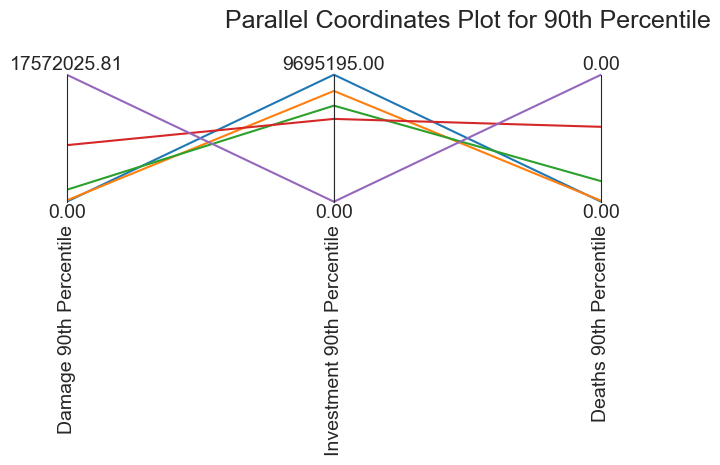

<Figure size 1400x600 with 0 Axes>

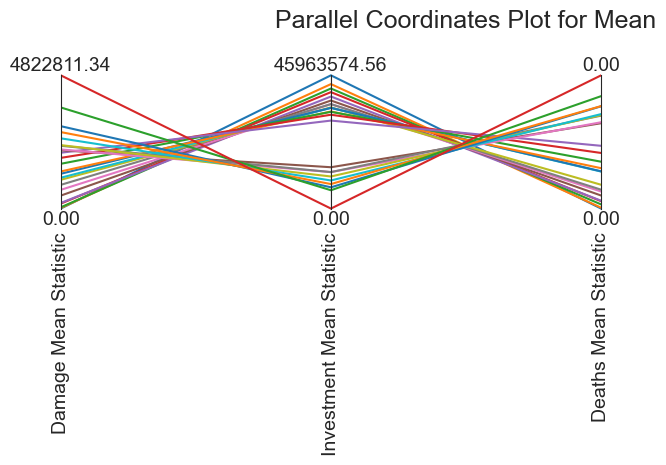

In [15]:
# Example usage
plot_parallel_coordinates(nondominated_90, '90th Percentile')
plot_parallel_coordinates(nondominated_mean, 'Mean')

The outputted plot above show us all different mean based and 90th percentile based non-dominated policies. 